In [1]:
# Import required libraries
import amber as am
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import numpy as np
import polars as pl


In [2]:
class TreeAgent(am.Agent):
    """A tree agent that can be alive, burning, or burned."""
    
    def __init__(self, model, agent_id):
        super().__init__(model, agent_id)
        self.condition = 0  # 0: Alive, 1: Burning, 2: Burned
        self.position = None
    
    def setup(self):
        pass

class ForestModel(am.Model):
    
    def setup(self):
        
        # Initialize DataFrame with correct columns for forest model
        self.agents_df = pl.DataFrame({
            'id': pl.Series([], dtype=pl.Int64),
            'step': pl.Series([], dtype=pl.Int64),
            'condition': pl.Series([], dtype=pl.Int64),
            'x': pl.Series([], dtype=pl.Int64),
            'y': pl.Series([], dtype=pl.Int64)
        })
        
        # Create agents (trees) 
        tree_density = self.p['tree_density'] / 100.0 if self.p['tree_density'] > 1 else self.p['tree_density']
        n_trees = int(tree_density * (self.p['size']**2))
        
        # Create tree agents
        self.tree_agents = {}
        for i in range(n_trees):
            agent = TreeAgent(self, i)
            agent.setup()
            self.tree_agents[i] = agent
        
        # Randomly place trees on the grid
        available_positions = [(x, y) for x in range(self.p['size']) for y in range(self.p['size'])]
        selected_positions = self.random.sample(available_positions, n_trees)
        
        # Create position mapping for quick neighbor lookup
        self.grid = {}  # (x, y) -> agent_id
        for i, (x, y) in enumerate(selected_positions):
            self.tree_agents[i].position = (x, y)
            self.grid[(x, y)] = i
            
        # Start a fire from the left side of the grid (x=0 or x=1)
        for agent_id, agent in self.tree_agents.items():
            if agent.position[0] <= 1:  # Left side of grid
                agent.condition = 1  # Start burning
        
        # Record initial state
        self._record_all_agents()
        
    def get_neighbors(self, position):
        """Get neighboring positions (4-directional)."""
        x, y = position
        neighbors = []
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.p['size'] and 0 <= ny < self.p['size']:
                if (nx, ny) in self.grid:
                    neighbors.append((nx, ny))
        return neighbors
        
    def _record_all_agents(self):
        """Record current state of all agents."""
        agent_data = []
        for agent_id, agent in self.tree_agents.items():
            agent_data.append({
                'id': agent_id,
                'step': self.t,
                'condition': agent.condition,
                'x': agent.position[0] if agent.position else None,
                'y': agent.position[1] if agent.position else None
            })
        
        if agent_data:
            new_data = pl.DataFrame(agent_data)
            self.agents_df = pl.concat([self.agents_df, new_data])
        
    def step(self):
        
        # Get currently burning trees
        burning_trees = [agent for agent in self.tree_agents.values() if agent.condition == 1]
        
        if not burning_trees:
            return  # No more fire to spread
            
        # Spread fire to neighbors
        new_burning = []
        for tree in burning_trees:
            # Get neighboring positions
            neighbor_positions = self.get_neighbors(tree.position)
            
            # Check each neighbor
            for neighbor_pos in neighbor_positions:
                neighbor_id = self.grid[neighbor_pos]
                neighbor = self.tree_agents[neighbor_id]
                if neighbor.condition == 0:  # Alive tree
                    neighbor.condition = 1  # Start burning
                    new_burning.append(neighbor_id)
            
            # Tree burns out
            tree.condition = 2
            
        # Record changes
        self._record_all_agents()
        
        # Stop if no new trees are burning
        if not new_burning:
            self.record_model('simulation_ended', True)
            
    def end(self):
        
        # Calculate percentage of burned trees
        burned_count = sum(1 for agent in self.tree_agents.values() if agent.condition == 2)
        total_trees = len(self.tree_agents)
        percentage = burned_count / total_trees if total_trees > 0 else 0
        
        self.record_model('percentage_burned_trees', percentage)
        
    def get_grid_for_visualization(self):
        """Get grid state for visualization."""
        grid_state = np.full((self.p['size'], self.p['size']), None)
        
        for agent in self.tree_agents.values():
            if agent.position:
                x, y = agent.position
                grid_state[y, x] = agent.condition  # Note: y, x for matplotlib
                
        return grid_state


In [3]:
# Define parameters
parameters = {
    'tree_density': 0.6, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 100,
}


In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def create_forest_animation(parameters, max_steps=50):
    """Create an animated visualization of the forest fire simulation."""
    print("🔥 Creating forest fire animation...")
    
    # Initialize model
    model = ForestModel(parameters)
    model.setup()
    model.update()
    
    # Store simulation states
    states = []
    step_count = 0
    
    # Run simulation and collect states
    while step_count < max_steps:
        # Record current state
        grid_state = model.get_grid_for_visualization()
        alive_count = sum(1 for agent in model.tree_agents.values() if agent.condition == 0)
        states.append({
            'grid': grid_state.copy(),
            'step': model.t,
            'alive': alive_count
        })
        
        if step_count > 0:
            model.step()
            model.update()
            
            # Check if simulation ended early
            if hasattr(model, '_model_data') and model._model_data:
                if model._model_data[-1].get('simulation_ended', False):
                    print(f"🔥 Fire spread completed at step {step_count}")
                    break
        
        step_count += 1
    
    model.end()
    
    # Create animation
    fig, ax = plt.subplots(figsize=(10, 8))
    
    def animate(frame):
        ax.clear()
        state = states[frame]
        grid_state = state['grid']
        
        # Convert grid to colored array
        colored_grid = np.full((*grid_state.shape, 3), [0.839, 0.898, 0.839])  # Light green background
        
        for i in range(grid_state.shape[0]):
            for j in range(grid_state.shape[1]):
                value = grid_state[i, j]
                if value == 0:  # Alive
                    colored_grid[i, j] = [0.498, 0.788, 0.498]  # Green
                elif value == 1:  # Burning
                    colored_grid[i, j] = [0.839, 0.173, 0.173]  # Red
                elif value == 2:  # Burned
                    colored_grid[i, j] = [0.898, 0.898, 0.898]  # Gray
        
        ax.imshow(colored_grid, interpolation='nearest')
        ax.set_title(f"Forest Fire Simulation\nStep: {state['step']}, Trees left: {state['alive']}")
        ax.set_xticks([])
        ax.set_yticks([])
        
        return ax.collections
    
    # Create animation
    anim = FuncAnimation(fig, animate, frames=len(states), interval=200, blit=False, repeat=True)
    
    print(f"✅ Animation created with {len(states)} frames")
    plt.close()  # Close the figure to prevent static display
    
    return HTML(anim.to_jshtml())

# Create and display the animation
forest_animation = create_forest_animation(parameters, max_steps=100)
forest_animation


🔥 Creating forest fire animation...
✅ Animation created with 100 frames


In [5]:
# Prepare parameter sample
parameters = {
    'tree_density': am.IntRange(20, 60),  # Will be divided by 100 to get 0.2-0.6
    'size': 100
}
sample = am.Sample(parameters, n=30)


In [6]:
# Perform experiment
exp = am.Experiment(ForestModel, sample, iterations=10)  # Reduced iterations for demo
results = exp.run()


🚀 Starting simulation: ForestModel
📊 Parameters: {'size': 100, 'tree_density': 20, 'iteration': 0}
⏱️  Total steps: 100
🕐 Started at: 19:35:01

🔄 Step 100/100 [██████████████████████████████] 100.0% | Elapsed: 0:00:00 | ETA: 0:00:00

✅ Simulation completed!
⏱️  Total time: 0:00:00
   • Setup: 0.004s
   • Steps: 0.006s (0.06ms/step)
   • Cleanup: 0.000s
📈 Performance: 7101.4 steps/second
🕐 Finished at: 19:35:01
🚀 Starting simulation: ForestModel
📊 Parameters: {'size': 100, 'tree_density': 20, 'iteration': 1}
⏱️  Total steps: 100
🕐 Started at: 19:35:01

🔄 Step 100/100 [██████████████████████████████] 100.0% | Elapsed: 0:00:00 | ETA: 0:00:00

✅ Simulation completed!
⏱️  Total time: 0:00:00
   • Setup: 0.005s
   • Steps: 0.006s (0.06ms/step)
   • Cleanup: 0.000s
📈 Performance: 7143.3 steps/second
🕐 Finished at: 19:35:01
🚀 Starting simulation: ForestModel
📊 Parameters: {'size': 100, 'tree_density': 20, 'iteration': 2}
⏱️  Total steps: 100
🕐 Started at: 19:35:01

🔄 Step 100/100 [████████████

In [7]:
# Results are already available as a dictionary with polars DataFrames
# No need to save/load for this example
print("Experiment completed!")
print(f"Total parameter combinations: {len(results['parameters'])}")
print(f"Agent data shape: {results['agents'].shape}")
print(f"Model data shape: {results['model'].shape}")

# Check what columns we actually have
print("\nAvailable columns in model data:")
print(results['model'].columns)
print("\nSample of model data:")
print(results['model'].head())

# Check what columns we have in agent data
print("\nAvailable columns in agent data:")
print(results['agents'].columns)
print("\nSample of agent data:")
print(results['agents'].head())


Experiment completed!
Total parameter combinations: 30
Agent data shape: (38012138, 8)
Model data shape: (30000, 4)

Available columns in model data:
['t', 'size', 'tree_density', 'iteration']

Sample of model data:
shape: (5, 4)
┌─────┬──────┬──────────────┬───────────┐
│ t   ┆ size ┆ tree_density ┆ iteration │
│ --- ┆ ---  ┆ ---          ┆ ---       │
│ i64 ┆ i32  ┆ i32          ┆ i32       │
╞═════╪══════╪══════════════╪═══════════╡
│ 1   ┆ 100  ┆ 20           ┆ 0         │
│ 2   ┆ 100  ┆ 20           ┆ 0         │
│ 3   ┆ 100  ┆ 20           ┆ 0         │
│ 4   ┆ 100  ┆ 20           ┆ 0         │
│ 5   ┆ 100  ┆ 20           ┆ 0         │
└─────┴──────┴──────────────┴───────────┘

Available columns in agent data:
['id', 'step', 'condition', 'x', 'y', 'size', 'tree_density', 'iteration']

Sample of agent data:
shape: (5, 8)
┌─────┬──────┬───────────┬─────┬─────┬──────┬──────────────┬───────────┐
│ id  ┆ step ┆ condition ┆ x   ┆ y   ┆ size ┆ tree_density ┆ iteration │
│ --- ┆ ---  ┆ -

Calculating percentage burned trees from agent data...
Calculated burn statistics for 300 runs

Sample burn statistics:
shape: (5, 6)
┌──────────────┬───────────┬─────────────┬──────────────┬───────────────────┬──────────────────┐
│ tree_density ┆ iteration ┆ total_trees ┆ burned_trees ┆ percentage_burned ┆ tree_density_pct │
│ ---          ┆ ---       ┆ ---         ┆ ---          ┆ ---               ┆ ---              │
│ i32          ┆ i32       ┆ u32         ┆ u32          ┆ f64               ┆ f64              │
╞══════════════╪═══════════╪═════════════╪══════════════╪═══════════════════╪══════════════════╡
│ 24           ┆ 6         ┆ 2400        ┆ 61           ┆ 0.025417          ┆ 0.24             │
│ 35           ┆ 0         ┆ 3500        ┆ 171          ┆ 0.048857          ┆ 0.35             │
│ 40           ┆ 6         ┆ 4000        ┆ 161          ┆ 0.04025           ┆ 0.4              │
│ 22           ┆ 3         ┆ 2200        ┆ 66           ┆ 0.03              ┆ 0.22        

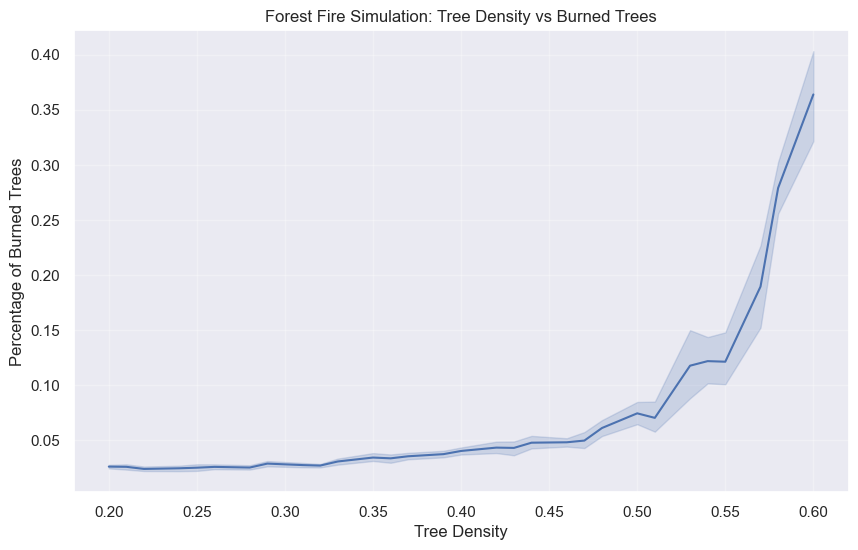


Summary Statistics:
shape: (30, 5)
┌──────────────┬─────────────┬────────────┬────────┬──────────────────┐
│ tree_density ┆ mean_burned ┆ std_burned ┆ n_runs ┆ tree_density_pct │
│ ---          ┆ ---         ┆ ---        ┆ ---    ┆ ---              │
│ i32          ┆ f64         ┆ f64        ┆ u32    ┆ f64              │
╞══════════════╪═════════════╪════════════╪════════╪══════════════════╡
│ 51           ┆ 0.070333    ┆ 0.024988   ┆ 10     ┆ 0.51             │
│ 20           ┆ 0.0261      ┆ 0.002797   ┆ 10     ┆ 0.2              │
│ 28           ┆ 0.02525     ┆ 0.003329   ┆ 10     ┆ 0.28             │
│ 31           ┆ 0.027484    ┆ 0.003314   ┆ 10     ┆ 0.31             │
│ 24           ┆ 0.024583    ┆ 0.004272   ┆ 10     ┆ 0.24             │
│ …            ┆ …           ┆ …          ┆ …      ┆ …                │
│ 43           ┆ 0.04307     ┆ 0.010676   ┆ 10     ┆ 0.43             │
│ 58           ┆ 0.278931    ┆ 0.043385   ┆ 10     ┆ 0.58             │
│ 46           ┆ 0.048174   

In [8]:
# Calculate percentage burned from agent data since model data might not have it
print("Calculating percentage burned trees from agent data...")

# Get the final step for each run
final_step_agents = results['agents'].group_by(['tree_density', 'iteration']).agg([
    pl.col('step').max().alias('final_step')
])

# Get final agent states
final_agents = results['agents'].join(
    final_step_agents, 
    on=['tree_density', 'iteration']
).filter(pl.col('step') == pl.col('final_step'))

# Calculate percentage burned for each run
burn_stats = final_agents.group_by(['tree_density', 'iteration']).agg([
    pl.col('condition').count().alias('total_trees'),
    (pl.col('condition') == 2).sum().alias('burned_trees')
]).with_columns([
    (pl.col('burned_trees') / pl.col('total_trees')).alias('percentage_burned')
])

# Convert tree_density to percentage for plotting
plot_data = burn_stats.with_columns([
    (pl.col('tree_density') / 100.0).alias('tree_density_pct')
])

print(f"Calculated burn statistics for {len(plot_data)} runs")
print("\nSample burn statistics:")
print(plot_data.head())

# Plot sensitivity analysis
sns.set_theme()
plot_data_pd = plot_data.to_pandas()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_data_pd, 
    x='tree_density_pct', 
    y='percentage_burned'
)
plt.title('Forest Fire Simulation: Tree Density vs Burned Trees')
plt.xlabel('Tree Density')
plt.ylabel('Percentage of Burned Trees')
plt.grid(True, alpha=0.3)
plt.show()

# Show summary statistics
print("\nSummary Statistics:")
summary = plot_data.group_by('tree_density').agg([
    pl.col('percentage_burned').mean().alias('mean_burned'),
    pl.col('percentage_burned').std().alias('std_burned'),
    pl.col('percentage_burned').count().alias('n_runs')
]).with_columns([
    (pl.col('tree_density') / 100.0).alias('tree_density_pct')
])
print(summary)
